# Автоматизация выявления аномального и злонамеренного трафика

## Цель проекта: Разработать проект, который будет классифицировать трафик на нормальный и злонамеренный.


Компания онлайн-сервис с высоким уровнем входящего трафика имеет специализированный отдел безопасности, который занимается фильтрацией и анализом трафика. Сотрудники этого отдела обратились за помощью в автоматизации выявления аномального и злонамеренного трафика. 
Задача - разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный, включая следующие типы атак: DDoS, SQL-инъекции, брутфорс, вредоносные программы и т.д.

Перед нами стоит задача мультиклассовой классификации, целевым признаком является столбец label, в котором содержаться данные 15 значений, один из которых является нормальный трафик, остальный 14 видов значений атаки.

Основные этапы исследования:
1. Загрузка и изучение данных
2. Предварительная обработка
3. Разведочный анализ
4. Pазработка новых синтетических признаков, проверка на мультиколлинеарность
5. Отбор финального набора обучающих признаков
6. Выбор и обучение моделей
7. Итоговая оценка качества предсказания лучшей модели
8. Анализ важности ее признаков.

## 1. Загрузка и изучение данных

In [1]:
pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from imblearn.over_sampling import SMOTE
import re

from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

RANDOM_STATE = 2023

pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv("C:/Users/User/Documents/проекты/final_steel/network_traffic_data.csv")   
display(df.sample(5))
print("Размер df:", df.shape)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
318438,80,100590843,6,8,676,11595,332,0,112.70,169.9,5792,0,1449.0,1896.0,121.989235,0.139178,7737757.000,27800000.00,100000000,6,100000000,20100000.00,44800000.00,100000000,6,101000000,14400000.0,37900000.00,100000000,45,0,0,0,0,176,264,0.059648,0.079530,0,5792,818.5,1515.0,2.295593e+06,1,0,0,0,0,0,0,0,1,877.0,112.70,1449.0,176,0,0,0,0,0,0,6,676,8,11595,0,235,3,20,8965.0,0.0,8965,8965,100000000.0,0.0,100000000,100000000,DoS Hulk
447754,80,86036042,7,6,374,11595,374,0,53.44,141.4,5792,0,1932.0,2182.0,139.116116,0.151099,7169670.000,24800000.00,85900000,0,85900000,14300000.00,35100000.00,85900000,0,150462,30092.4,59589.26,136141,45,0,0,0,0,232,200,0.081361,0.069738,0,5792,855.0,1666.0,2.776812e+06,0,0,0,0,1,0,0,0,0,920.5,53.44,1932.0,232,0,0,0,0,0,0,7,374,6,11595,251,235,1,32,1001.0,0.0,1001,1001,85900000.0,0.0,85900000,85900000,DoS Hulk
503015,80,5780414,3,1,0,0,0,0,0.00,0.0,0,0,0.0,0.0,0.000000,0.691992,1926804.600,3336571.00,5779545,130,5780414,2890207.00,4086141.00,5779545,869,0,0.0,0.00,0,0,0,0,0,0,104,40,0.518994,0.172998,0,0,0.0,0.0,0.000000e+00,0,0,0,1,0,0,0,0,0,0.0,0.00,0.0,104,0,0,0,0,0,0,3,0,1,0,29200,28960,0,32,0.0,0.0,0,0,0.0,0.0,0,0,Web Attack � Brute Force
235470,53,111176,1,1,53,88,53,53,53.00,0.0,88,88,88.0,0.0,1268.259337,17.989494,111176.000,0.00,111176,111176,0,0.00,0.00,0,0,0,0.0,0.00,0,0,0,0,0,0,20,40,8.994747,8.994747,53,88,64.7,20.2,4.083333e+02,0,0,0,0,0,0,0,0,1,97.0,53.00,88.0,20,0,0,0,0,0,0,1,53,1,88,-1,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
70470,443,1055870,9,11,703,3950,267,0,78.10,103.3,1448,0,359.0,570.0,4406.792503,18.941726,55572.105,85360.03,344851,3,960094,120011.75,148504.38,440112,241,960795,96079.5,110536.46,344851,3,0,0,0,0,296,360,8.523777,10.417949,0,1448,221.6,434.5,1.887895e+05,0,0,0,1,0,0,0,0,1,232.6,78.10,359.0,296,0,0,0,0,0,0,9,703,11,3950,29200,252,4,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


Размер df: (539616, 79)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539616 entries, 0 to 539615
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             539616 non-null  int64  
 1    Flow Duration                539616 non-null  int64  
 2    Total Fwd Packets            539616 non-null  int64  
 3    Total Backward Packets       539616 non-null  int64  
 4   Total Length of Fwd Packets   539616 non-null  int64  
 5    Total Length of Bwd Packets  539616 non-null  int64  
 6    Fwd Packet Length Max        539616 non-null  int64  
 7    Fwd Packet Length Min        539616 non-null  int64  
 8    Fwd Packet Length Mean       539616 non-null  float64
 9    Fwd Packet Length Std        539616 non-null  float64
 10  Bwd Packet Length Max         539616 non-null  int64  
 11   Bwd Packet Length Min        539616 non-null  int64  
 12   Bwd Packet Length Mean       539616 non-nul

In [5]:
df.describe(include='all').round(2).T.drop(
    index='Label', columns='count'
).style.background_gradient(subset=['mean', '50%'],
                            vmin=0,
                            vmax=10000,
                            high=0.8,
                            cmap='YlGnBu')

,unique,top,freq,mean,std,min,25%,50%,75%,max
Destination Port,nan,nan,nan,5563.060000,14921.260000,0.000000,80.000000,80.000000,443.000000,65533.000000
Flow Duration,nan,nan,nan,21066929.370000,38121719.630000,-12.000000,73.000000,49739.000000,10640295.250000,119999993.000000
Total Fwd Packets,nan,nan,nan,6.120000,345.110000,1.000000,1.000000,2.000000,6.000000,200755.000000
Total Backward Packets,nan,nan,nan,5.990000,463.490000,0.000000,1.000000,2.000000,5.000000,270686.000000
Total Length of Fwd Packets,nan,nan,nan,408.240000,7478.350000,0.000000,2.000000,44.000000,320.000000,2866110.000000
Total Length of Bwd Packets,nan,nan,nan,7999.780000,1014441.800000,0.000000,0.000000,105.000000,8216.250000,591000000.000000
Fwd Packet Length Max,nan,nan,nan,169.450000,560.530000,0.000000,2.000000,23.000000,272.000000,24820.000000
Fwd Packet Length Min,nan,nan,nan,11.860000,60.960000,0.000000,0.000000,0.000000,6.000000,2065.000000
Fwd Packet Length Mean,nan,nan,nan,44.680000,150.870000,0.000000,2.000000,11.220000,48.560000,5940.000000
Fwd Packet Length Std,nan,nan,nan,59.530000,217.730000,0.000000,0.000000,0.000000,91.700000,7050.000000


Данный датафрейм содержит 539616 строк и 79 столбцов, один из которых категориальный признак, являющийся таргетом, "label". Столбцы "Fwd Header Length", "Bwd Header Length", "Fwd Header Length.1", "min_seg_size_forward" в среднем имеют отрицательные значения. Мы заметили что два столбца Flow Bytes/s и Flow Packets/s имеют среднее значение inf, в дальнейшем заменим это значение. Столбец "Flow Bytes/s" имеет пропущенные значения.

In [6]:
df.columns = [x.lower() for x in df.columns] #приведем к нижнему регистру названия столбцов

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


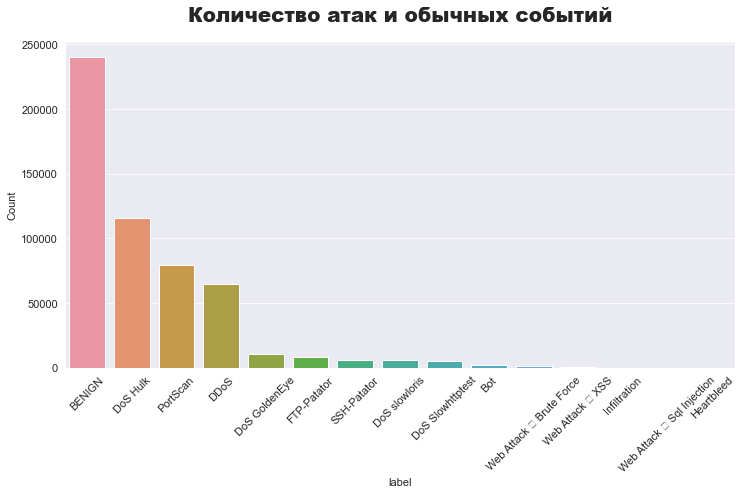

In [7]:
#посмотрим на количество событий в целевом признаке
plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (12,8)
font = {"size"   : 11}
plt.rc('font', **font)

grouped_labels = df.groupby("label")["label"].count().sort_values(ascending=False)
plt.xticks(rotation=45)


sns.barplot(x=grouped_labels.index, y=grouped_labels.values)
plt.title("Количество атак и обычных событий", pad=20, fontweight="black", fontsize=20)
plt.ylabel("Count");

In [8]:
#посмотрим на количество значений классов таргета
df['label'].value_counts()

BENIGN                        240000
DoS Hulk                      115974
PortScan                       79660
DDoS                           64366
DoS GoldenEye                  10293
FTP-Patator                     7938
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1966
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: label, dtype: int64

В целевом признаке самую большую часть занимает нормальный трафик benign 44%, затем злонамеренный трафики, такие как dos hulk 21%, portscan 15% и в меньшей степени остальные. Значит у нас есть не сбалансированные данные.

## Предварительная обработка

In [9]:
#преобразуем названия столбцов в питоновский вид, также преобразуем значения таргета
def clean_column_name(name):
    name = name.lower()
    name = name.replace('/', '_')
    name = name.replace('-', '_')
    name = name.replace("�", "")
    name = name.replace(" ", "_")
    name = name.replace('.', '_')
    name = re.sub(r"(?<=\d)_(?=\d)", "", name)
    return name

df.columns = df.columns.map(clean_column_name)
df.label = df.label.map(clean_column_name)

In [10]:
#проверим наличие дубликатов
dubl = df[df.duplicated(keep='last')]
dubl.shape

(64601, 79)

In [11]:
#удалим дубликаты
df.drop_duplicates(inplace=True)

In [12]:
#проверим после удаления дубликатов количество классов в таргете
df.label.value_counts()

benign                       232809
dos_hulk                      87251
ddos                          64364
portscan                      56397
dos_goldeneye                 10286
ftp_patator                    5933
dos_slowloris                  5385
dos_slowhttptest               5228
ssh_patator                    3219
bot                            1953
web_attack__brute_force        1470
web_attack__xss                 652
infiltration                     36
web_attack__sql_injection        21
heartbleed                       11
Name: label, dtype: int64

В данных есть не только дубликаты, но и неинформативные значения, заменим их на пропуски и затем заполним медианным значением, так как данные пропущенных столбцов имеют как отрицательные, так и положительные значения, они более оптимально повлияют на нашу метрику. Так же в данных есть столбцы только с одним значением, удалим их.

In [13]:
# заменим неинформативные значения в датафрейме на Nan
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [14]:
[col for col in df.columns if df[col].isnull().sum() > 0] #проверим пропущенные значения

['flow_bytes_s', '_flow_packets_s']

In [15]:
myImputer = SimpleImputer(strategy= 'median') #используем стратегию замены медианным значением

df['flow_bytes_s'] = myImputer.fit_transform(df['flow_bytes_s'].values.reshape(-1,1))
df['_flow_packets_s'] = myImputer.fit_transform(df['_flow_packets_s'].values.reshape(-1,1))

In [16]:
#посмотрим какие столбцы содержат только одно значение 
[col for col in df.columns if df[col].nunique() == 1]

['_bwd_psh_flags',
 '_bwd_urg_flags',
 'fwd_avg_bytes_bulk',
 '_fwd_avg_packets_bulk',
 '_fwd_avg_bulk_rate',
 '_bwd_avg_bytes_bulk',
 '_bwd_avg_packets_bulk',
 'bwd_avg_bulk_rate']

In [17]:
#удалим столбцы
df.drop(['_bwd_psh_flags',
 '_bwd_urg_flags',
 'fwd_avg_bytes_bulk',
 '_fwd_avg_packets_bulk',
 '_fwd_avg_bulk_rate',
 '_bwd_avg_bytes_bulk',
 '_bwd_avg_packets_bulk',
 'bwd_avg_bulk_rate'
 ], axis=1, inplace=True)

## Разведовочный анализ

In [18]:
#создадим маску для корреляции, в которой укажем условие, чтобы попадали сильно зависимые столбцы
corr = df.corr()
mask = (df.corr() > 0.9) & (df.corr() < 1.0)
high_corr = corr[mask]

col_to_filter_out = ~high_corr[mask].any()
X_clean = df[high_corr.columns[col_to_filter_out]]
X_clean

,_destination_port,total_length_of_fwd_packets,_fwd_packet_length_min,_fwd_packet_length_mean,_bwd_packet_length_min,flow_bytes_s,_flow_iat_mean,_flow_iat_min,_fwd_iat_mean,_fwd_iat_min,bwd_iat_total,_bwd_iat_mean,_bwd_iat_min,fwd_psh_flags,_fwd_urg_flags,_bwd_packets_s,_min_packet_length,fin_flag_count,_syn_flag_count,_rst_flag_count,_psh_flag_count,_ack_flag_count,_urg_flag_count,_cwe_flag_count,_ece_flag_count,_down_up_ratio,_avg_fwd_segment_size,_subflow_fwd_bytes,init_win_bytes_forward,_init_win_bytes_backward,_act_data_pkt_fwd,_active_std,_active_max,_idle_std
0,80,12,0,4.000,0,2.189751,1.826691e+06,101,2740037.000,37270,0,0.000,0,0,0,0.182479,0,0,0,0,1,0,0,0,0,0,4.000,12,8192,42780,2,0.0,0,0.0
1,443,703,0,78.100,0,6535.323473,3.955428e+04,1,77037.625,230,616874,68541.555,1,0,0,14.045398,0,0,0,0,1,0,0,0,0,1,78.100,703,29200,252,4,0.0,0,0.0
2,53,80,40,40.000,112,1981.772904,5.113267e+04,3,3.000,3,4,4.000,4,0,0,13.037980,40,0,0,0,0,0,0,0,0,1,40.000,80,-1,-1,1,0.0,0,0.0
3,53,46,46,46.000,128,3017.689906,5.766000e+04,57660,0.000,0,0,0.000,0,0,0,17.343046,46,0,0,0,0,0,0,0,0,1,46.000,46,-1,-1,0,0.0,0,0.0
4,8446,43,6,14.336,6,63885.267280,2.556667e+02,3,356.500,3,0,0.000,0,0,0,1303.781000,6,0,0,0,0,1,0,0,0,0,14.336,43,1017,0,2,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539611,80,326,0,40.750,0,1038.723775,9.593503e+05,1,930110.000,1,11500000,2878039.500,196,0,0,0.434322,0,0,0,0,1,0,0,0,0,0,40.750,326,29200,235,1,0.0,892,0.0
539612,80,471,0,94.200,0,347.076105,1.279258e+06,53,1628157.800,176,11500000,2878318.000,192,0,0,0.434279,0,0,0,0,1,0,0,0,0,1,94.200,471,29200,235,1,0.0,918,0.0
539613,80,314,0,44.840,0,1037.952157,9.591001e+05,46,1084509.400,255,11500000,2301830.500,47,0,0,0.521322,0,0,0,0,1,0,0,0,0,0,44.840,314,29200,235,1,0.0,899,0.0
539614,80,369,0,46.120,0,1042.740546,9.590912e+05,47,929684.900,168,11500000,2877262.000,196,0,0,0.434439,0,0,0,0,1,0,0,0,0,0,46.120,369,29200,235,1,0.0,914,0.0


В данных 34 столбца, которые сильно коррелируют друг с другом. На основе этих столбцов сгенирируем новые синтетические признаки и попробуем удалить некоторые столбцы

## Разработка новых синтетических признаков

In [19]:
df['_fwd_packet_new'] = df['_fwd_packet_length_min']+df['_fwd_packet_length_mean']+df['_min_packet_length']
df['_flow_iat_new'] = df['_flow_iat_mean']+df['_flow_iat_min']
df['_flow_iat_new_m'] = df['_fwd_iat_mean']+df['_fwd_iat_min']
df['bwd_iat_new'] = df['bwd_iat_total']+df['_bwd_iat_mean']+df['_bwd_iat_min']
df['_flow_new'] = df['_flow_iat_new']+df['_flow_iat_new_m']+df['bwd_iat_new']
df['_fwd_flags_new'] = df['fwd_psh_flags']+df['_fwd_urg_flags']
df['flow_pasckets_bytes_new'] = df['flow_bytes_s']+df['_bwd_packets_s']
df['init_win_bytes_new'] = df['_init_win_bytes_backward']+df['init_win_bytes_forward']+df['_subflow_fwd_bytes']
df['active_new'] = df['_active_std']+df['_active_max']

Так как данные содержат нулевые значения, которые могут содержать смысл в том, была атака или нет, мы сгенерировали новые признаки суммированием, чтобы не искозить данные другими математическими способами.

## Отбор финального набора обучающих признаков

In [20]:
df.drop(columns=['_fwd_packet_length_min', '_fwd_packet_length_mean', '_flow_iat_mean', '_flow_iat_min',\
                '_fwd_iat_mean', '_fwd_iat_min', 'bwd_iat_total', '_bwd_iat_mean', '_bwd_iat_min',
                '_min_packet_length', 'fwd_psh_flags', '_fwd_urg_flags', 'flow_bytes_s', '_bwd_packets_s',\
                '_init_win_bytes_backward', 'init_win_bytes_forward', '_flow_iat_new', '_flow_iat_new_m',\
                'bwd_iat_new', '_active_std', '_active_max'],\
        axis=1, inplace=True)

In [21]:
corr = df.corr()
mask = (df.corr() > 0.9) & (df.corr() < 1.0)
high_corr = corr[mask]

# Create a new column mask using any() and ~
col_to_filter_out = ~high_corr[mask].any()
X_clean_new = df[high_corr.columns[col_to_filter_out]]

# Visualize cleaned dataset
X_clean_new

,_destination_port,total_length_of_fwd_packets,_bwd_packet_length_min,fin_flag_count,_rst_flag_count,_psh_flag_count,_ack_flag_count,_urg_flag_count,_cwe_flag_count,_ece_flag_count,_down_up_ratio,_subflow_fwd_bytes,_act_data_pkt_fwd,_idle_std,_flow_new,flow_pasckets_bytes_new,init_win_bytes_new,active_new
0,80,12,0,0,0,1,0,0,0,0,0,12,2,0.0,4.604099e+06,2.372231,50984,0.0
1,443,703,0,0,0,1,0,0,0,0,1,703,4,0.0,8.022395e+05,6549.368871,30155,0.0
2,53,80,112,0,0,0,0,0,0,0,1,80,1,0.0,5.115367e+04,1994.810884,78,0.0
3,53,46,128,0,0,0,0,0,0,0,1,46,0,0.0,1.153200e+05,3035.032952,44,0.0
4,8446,43,6,0,0,0,1,0,0,0,0,43,2,0.0,6.181667e+02,65189.048280,1060,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539611,80,326,0,0,0,1,0,0,0,0,0,326,1,0.0,1.626770e+07,1039.158097,29761,892.0
539612,80,471,0,0,0,1,0,0,0,0,1,471,1,0.0,1.728616e+07,347.510385,29906,918.0
539613,80,314,0,0,0,1,0,0,0,0,0,314,1,0.0,1.584579e+07,1038.473479,29749,899.0
539614,80,369,0,0,0,1,0,0,0,0,0,369,1,0.0,1.626645e+07,1043.174985,29804,914.0


Мы видим что некоторые столбцы остались сильно коррелированные друг с другом, но пробывав удалить некоторые из них, наша метрика падает, поэтому оставим эти признаки в датасете.

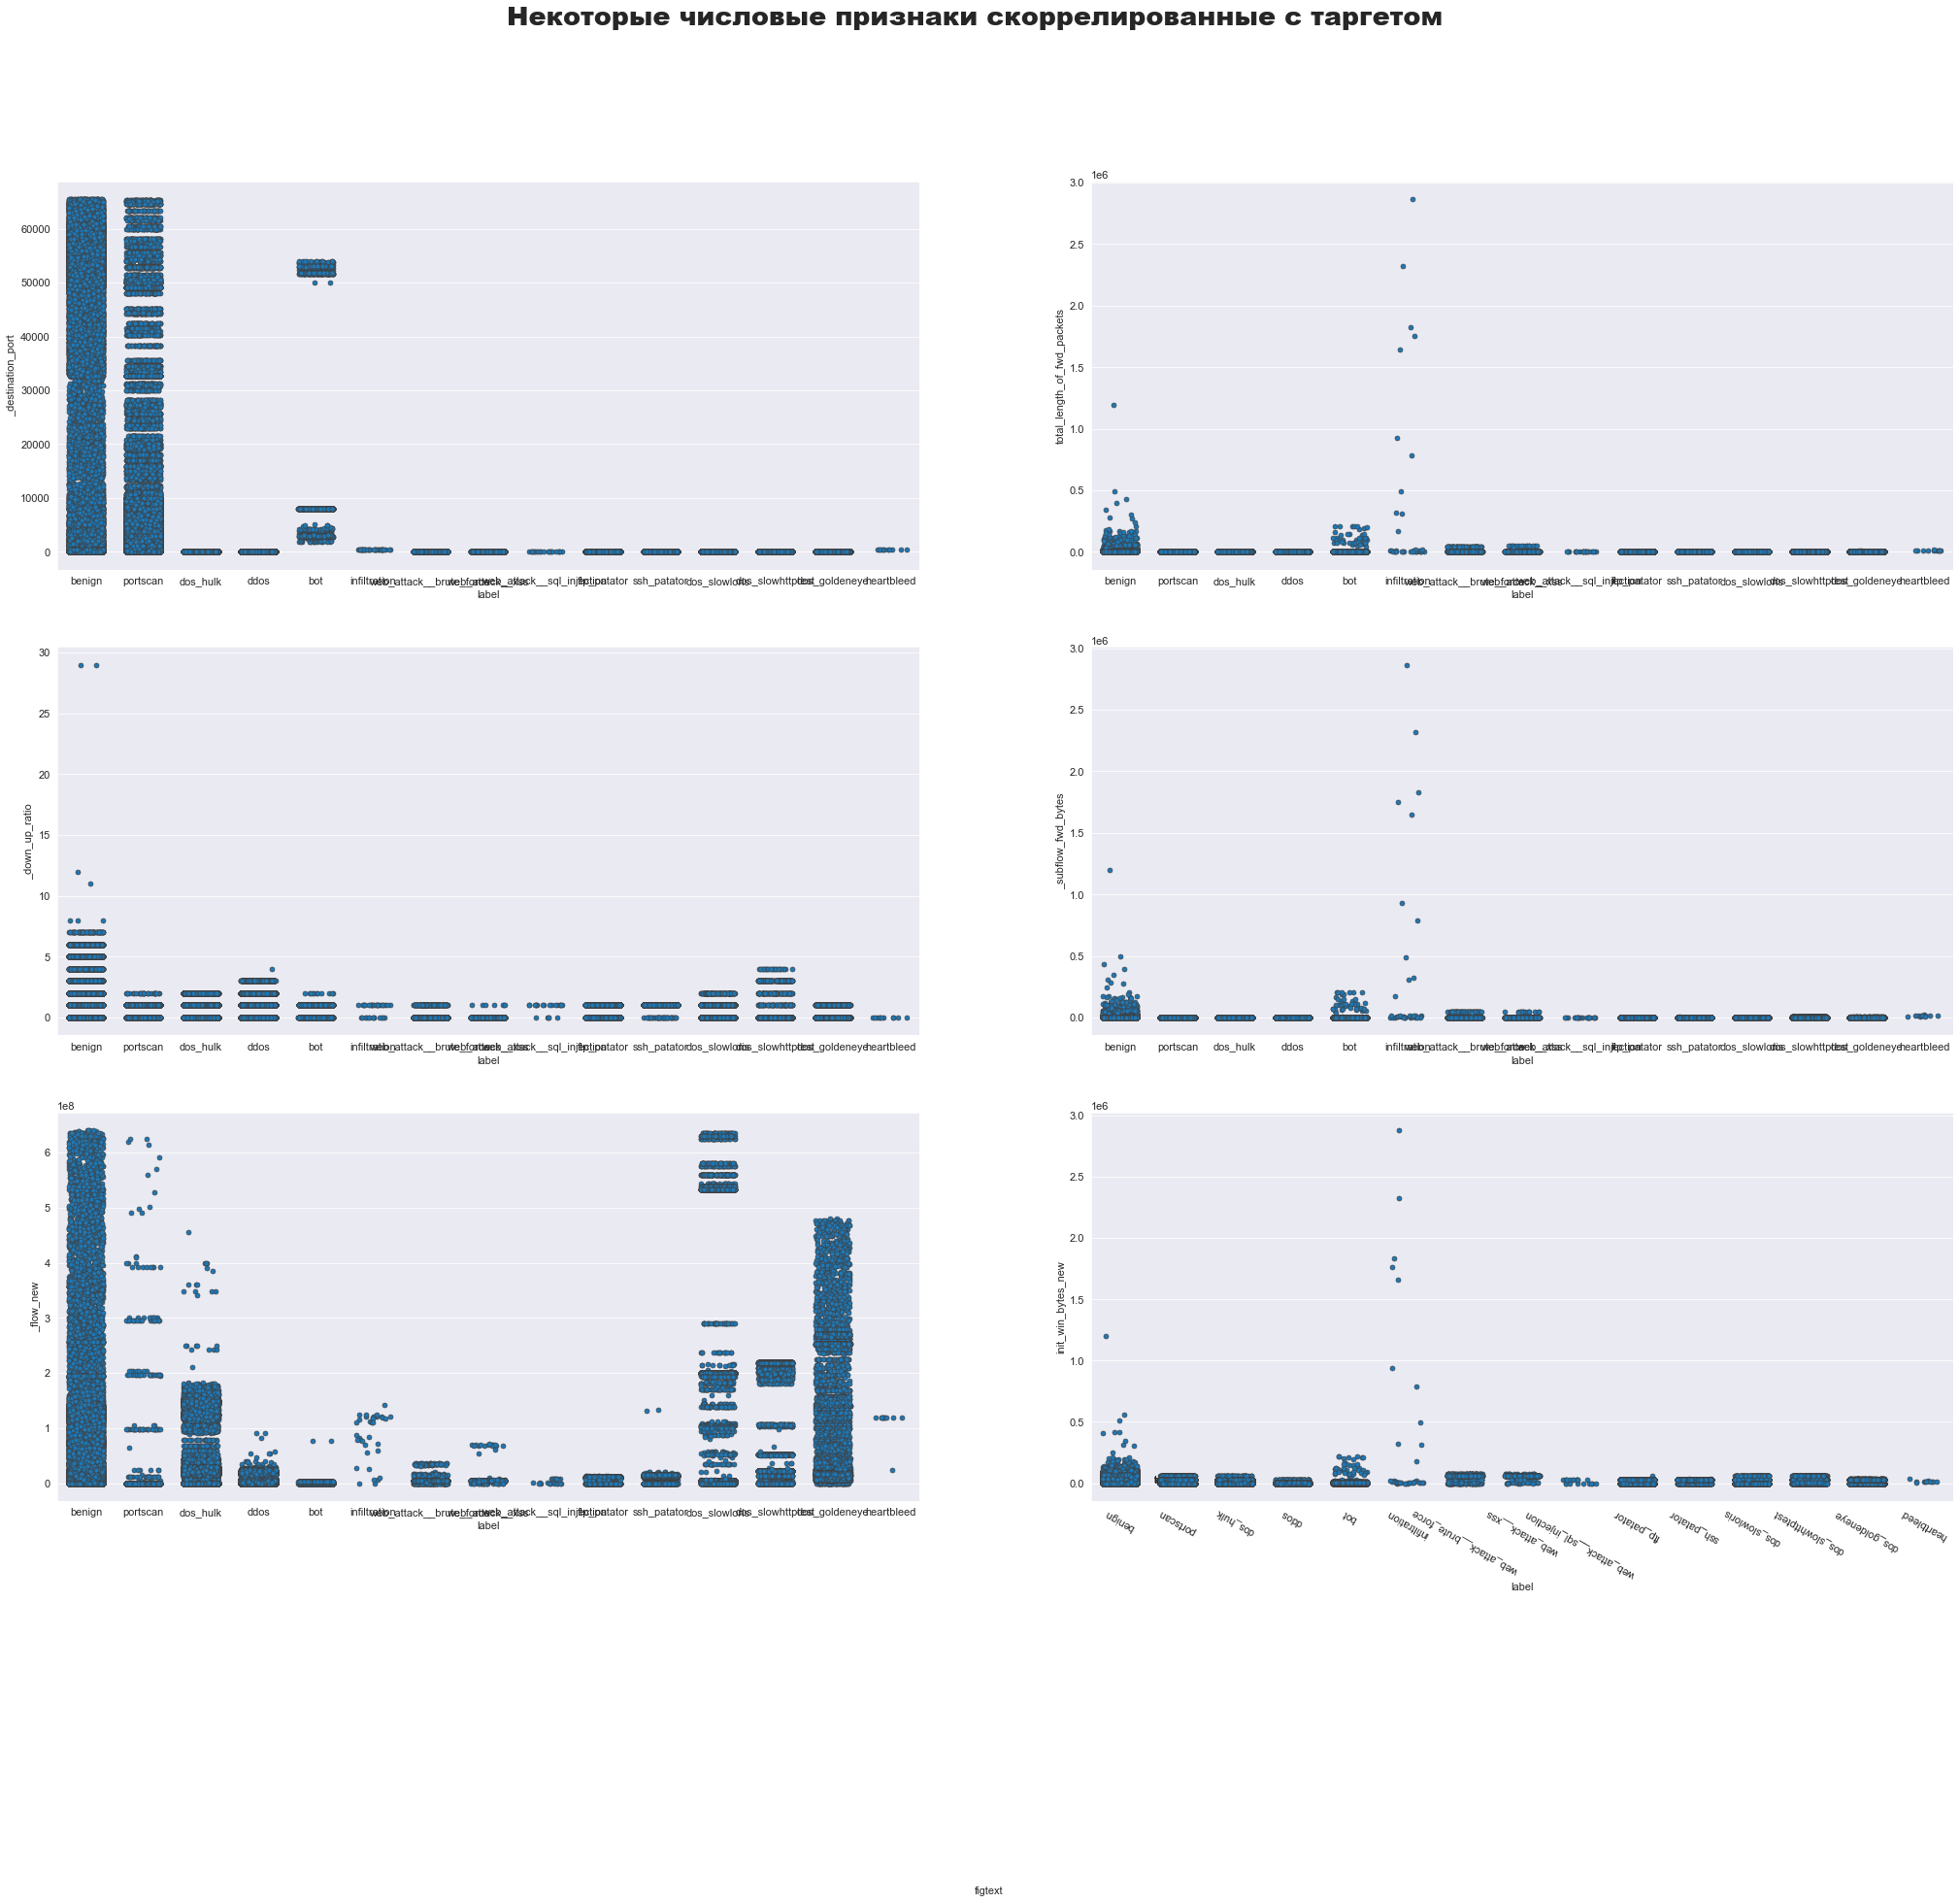

In [22]:
fig, axes = plt.subplots(3,2,figsize=(35,25))
fig.suptitle('Некоторые числовые признаки скоррелированные с таргетом', fontweight="black", fontsize=27)
sns.set_style('whitegrid')
plt.xticks(rotation=150)


plt.figtext(0.5, -0.1, "figtext")
sns.stripplot(x=df.label, y=df._destination_port, linewidth=0.6, jitter= 0.3, ax=axes[0, 0])
plt.text(0.6, 0.6, "text")
sns.stripplot(x=df.label, y=df.total_length_of_fwd_packets, linewidth=0.6, jitter= 0.3, ax=axes[0, 1])
plt.text(0.6, 0.6, "text")
sns.stripplot(x=df.label, y=df._down_up_ratio, linewidth=0.6, jitter= 0.3, ax=axes[1, 0])
plt.text(0.6, 0.6, "text")
sns.stripplot(x=df.label, y=df._subflow_fwd_bytes, linewidth=0.6, jitter= 0.3, ax=axes[1, 1])
plt.text(0.6, 0.6, "text")
sns.stripplot(x=df.label, y=df._flow_new, linewidth=0.6, jitter= 0.3, ax=axes[2, 0])
plt.text(0.6, 0.6, "text")
sns.stripplot(x=df.label, y=df.init_win_bytes_new, linewidth=0.6, jitter= 0.3, ax=axes[2, 1]);
None

Некоторые признаки похожи по своим значениям в визуальном пространстве, самое большое значение почти во всех принаках имеет нормальный трафик benign

In [23]:
#выделим признаки для обучения
X = df.drop(columns=['label'], inplace=False)
y = df["label"]

## Выбор и обучение моделей

In [24]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE)


print(f'''Количество объектов в тестовой выборке: {X_test.shape[0]}''')
print(f'''Количество обектов на обучающей выборке: {X_train.shape}''')
print(f'''Количество обектов на валидационной выборке: {X_val.shape}''')

Количество объектов в тестовой выборке: 71253
Количество обектов на обучающей выборке: (332510, 58)
Количество обектов на валидационной выборке: (71252, 58)


### 1. LogisticRegression

In [25]:
column_transformer = make_column_transformer((StandardScaler(), make_column_selector(dtype_include='number')),
                                             (OneHotEncoder(drop='first'), make_column_selector(dtype_include='object')),
                                              remainder='passthrough')

In [26]:
sm = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
y_train_res.value_counts()

benign                       162861
portscan                     162861
dos_hulk                     162861
dos_slowloris                162861
dos_slowhttptest             162861
ddos                         162861
web_attack__brute_force      162861
dos_goldeneye                162861
ftp_patator                  162861
web_attack__xss              162861
ssh_patator                  162861
bot                          162861
web_attack__sql_injection    162861
infiltration                 162861
heartbleed                   162861
Name: label, dtype: int64

In [27]:
pipeline_lr = Pipeline([
    ('datafeed', column_transformer),
    ('classifier', LogisticRegression())
])

pipeline_lr.fit(X_train_res, y_train_res)
y_pred_lr = pipeline_lr.predict(X_val)

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
print('Baselines LogisticRegression')
print(classification_report(y_val, y_pred_lr, digits=5))

Baselines LogisticRegression
                           precision    recall  f1-score   support

                   benign    0.99747   0.76661   0.86693     34946
                      bot    0.10310   0.97635   0.18651       296
                     ddos    0.89288   0.99753   0.94231      9718
            dos_goldeneye    0.72840   0.94370   0.82219      1563
                 dos_hulk    0.95267   0.95025   0.95146     13026
         dos_slowhttptest    0.72101   0.97986   0.83074       844
            dos_slowloris    0.55486   0.93743   0.69710       847
              ftp_patator    0.78820   0.99661   0.88024       885
               heartbleed    1.00000   1.00000   1.00000         3
             infiltration    0.00000   0.00000   0.00000         1
                 portscan    0.93154   0.98625   0.95812      8292
              ssh_patator    0.42179   0.93567   0.58147       513
  web_attack__brute_force    0.14719   0.44934   0.22174       227
web_attack__sql_injection    0.0

### 2.LinearSVC 

In [29]:
lin_svc = LinearSVC()
pipeline_svc = make_pipeline(column_transformer, lin_svc)
pipeline_svc.fit(X_train_res, y_train_res)
y_pred_svc = pipeline_svc.predict(X_val)

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [30]:
print('Baselines Linear SVC')
print(classification_report(y_val, y_pred_svc))

Baselines Linear SVC
                           precision    recall  f1-score   support

                   benign       1.00      0.76      0.86     34946
                      bot       0.08      0.99      0.14       296
                     ddos       0.96      1.00      0.98      9718
            dos_goldeneye       0.88      0.98      0.93      1563
                 dos_hulk       0.97      0.94      0.95     13026
         dos_slowhttptest       0.80      0.99      0.89       844
            dos_slowloris       0.56      0.98      0.71       847
              ftp_patator       0.96      1.00      0.98       885
               heartbleed       0.02      1.00      0.04         3
             infiltration       0.00      0.00      0.00         1
                 portscan       0.91      1.00      0.95      8292
              ssh_patator       0.78      0.98      0.87       513
  web_attack__brute_force       0.34      0.37      0.35       227
web_attack__sql_injection       0.01    

## 3. DecisionTreeClassifier

In [31]:
#закодируем целевой признак для деревянных моделей
X_train_enc = pd.get_dummies(X_train_res)

In [32]:
model_dt = DecisionTreeClassifier(class_weight = 'balanced', max_depth=5)
model_dt.fit(X_train_enc, y_train_res)
y_pred = model_dt.predict(X_val)

In [33]:
print('Baselines DecisionTreeClassifier')
print(classification_report(y_val, y_pred))

Baselines DecisionTreeClassifier


C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                           precision    recall  f1-score   support

                   benign       1.00      0.01      0.01     34946
                      bot       0.06      0.76      0.10       296
                     ddos       0.33      1.00      0.49      9718
            dos_goldeneye       0.07      1.00      0.13      1563
                 dos_hulk       0.00      0.00      0.00     13026
         dos_slowhttptest       0.00      0.00      0.00       844
            dos_slowloris       0.00      0.00      0.00       847
              ftp_patator       0.95      1.00      0.98       885
               heartbleed       1.00      1.00      1.00         3
             infiltration       0.50      1.00      0.67         1
                 portscan       0.65      0.93      0.76      8292
              ssh_patator       0.94      1.00      0.97       513
  web_attack__brute_force       0.01      0.05      0.01       227
web_attack__sql_injection       0.00      0.00      0.00     

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 4. RandomForestClassifier

In [34]:
model_rf = RandomForestClassifier(class_weight = 'balanced', max_depth=5, random_state=RANDOM_STATE,\
                                 n_estimators = 10, max_features = 1)
model_rf.fit(X_train_enc, y_train_res)
y_pred_rf = model_rf.predict(X_val)

In [35]:
print('Baselines RandomForestClassifier')
print(classification_report(y_val, y_pred_rf))

Baselines RandomForestClassifier
                           precision    recall  f1-score   support

                   benign       0.99      0.52      0.68     34946
                      bot       0.04      1.00      0.07       296
                     ddos       0.94      0.85      0.89      9718
            dos_goldeneye       0.64      0.69      0.66      1563
                 dos_hulk       0.99      0.89      0.93     13026
         dos_slowhttptest       0.42      0.82      0.55       844
            dos_slowloris       0.39      0.87      0.54       847
              ftp_patator       0.62      1.00      0.77       885
               heartbleed       1.00      1.00      1.00         3
             infiltration       0.00      0.00      0.00         1
                 portscan       0.65      0.99      0.78      8292
              ssh_patator       0.36      0.91      0.52       513
  web_attack__brute_force       0.59      0.12      0.20       227
web_attack__sql_injection   

### 5. KNeighborsClassifier

In [36]:
model_knn = KNeighborsClassifier(n_neighbors=1)
model_knn.fit(X_train_res, y_train_res)
y_pred_knn = model_knn.predict(X_val)

In [37]:
print('Baselines KNeighborsClassifier')
print(classification_report(y_val, y_pred_knn))

Baselines KNeighborsClassifier
                           precision    recall  f1-score   support

                   benign       0.99      0.98      0.99     34946
                      bot       0.64      0.86      0.73       296
                     ddos       0.99      1.00      0.99      9718
            dos_goldeneye       0.97      0.99      0.98      1563
                 dos_hulk       0.99      0.99      0.99     13026
         dos_slowhttptest       0.95      0.98      0.97       844
            dos_slowloris       0.96      0.97      0.97       847
              ftp_patator       0.99      1.00      0.99       885
               heartbleed       1.00      1.00      1.00         3
             infiltration       0.00      0.00      0.00         1
                 portscan       0.97      0.99      0.98      8292
              ssh_patator       0.91      0.99      0.95       513
  web_attack__brute_force       0.71      0.57      0.63       227
web_attack__sql_injection     

### 6. AdaBoostClassifier

In [38]:
ada_model = AdaBoostClassifier(learning_rate=0.1)
ada_model.fit(X_train_res, y_train_res)
y_pred_ada = ada_model.predict(X_val)

In [39]:
print('Baselines AdaBoostClassifier')
print(classification_report(y_val, y_pred_ada))

Baselines AdaBoostClassifier


C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                           precision    recall  f1-score   support

                   benign       0.69      0.96      0.80     34946
                      bot       0.00      0.00      0.00       296
                     ddos       0.00      0.00      0.00      9718
            dos_goldeneye       0.16      0.60      0.25      1563
                 dos_hulk       0.49      0.44      0.46     13026
         dos_slowhttptest       0.33      0.22      0.26       844
            dos_slowloris       0.23      0.97      0.38       847
              ftp_patator       0.00      0.00      0.00       885
               heartbleed       1.00      1.00      1.00         3
             infiltration       0.00      0.00      0.00         1
                 portscan       0.00      0.00      0.00      8292
              ssh_patator       0.00      0.00      0.00       513
  web_attack__brute_force       0.19      0.07      0.11       227
web_attack__sql_injection       0.00      1.00      0.00     

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Итоговая оценка качества предсказания лучшей модели

Лучшая модель ближайших соседей на обучающей выборке имеет accuracy 0,98 KNeighborsClassifier. Протестируем модель.

In [41]:
y_pred_knn = model_knn.predict(X_test)
print('Baselines on test KNeighborsClassifier')
print(classification_report(y_test, y_pred_knn))

Baselines on test KNeighborsClassifier
                           precision    recall  f1-score   support

                   benign       1.00      0.98      0.99     35002
                      bot       0.64      0.87      0.74       286
                     ddos       0.99      0.99      0.99      9648
            dos_goldeneye       0.98      0.99      0.98      1478
                 dos_hulk       0.99      0.99      0.99     13097
         dos_slowhttptest       0.93      0.99      0.96       760
            dos_slowloris       0.97      0.97      0.97       828
              ftp_patator       0.98      1.00      0.99       898
               heartbleed       0.33      1.00      0.50         1
             infiltration       0.29      0.78      0.42         9
                 portscan       0.97      0.99      0.98      8462
              ssh_patator       0.93      1.00      0.96       470
  web_attack__brute_force       0.61      0.60      0.61       197
web_attack__sql_inject

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


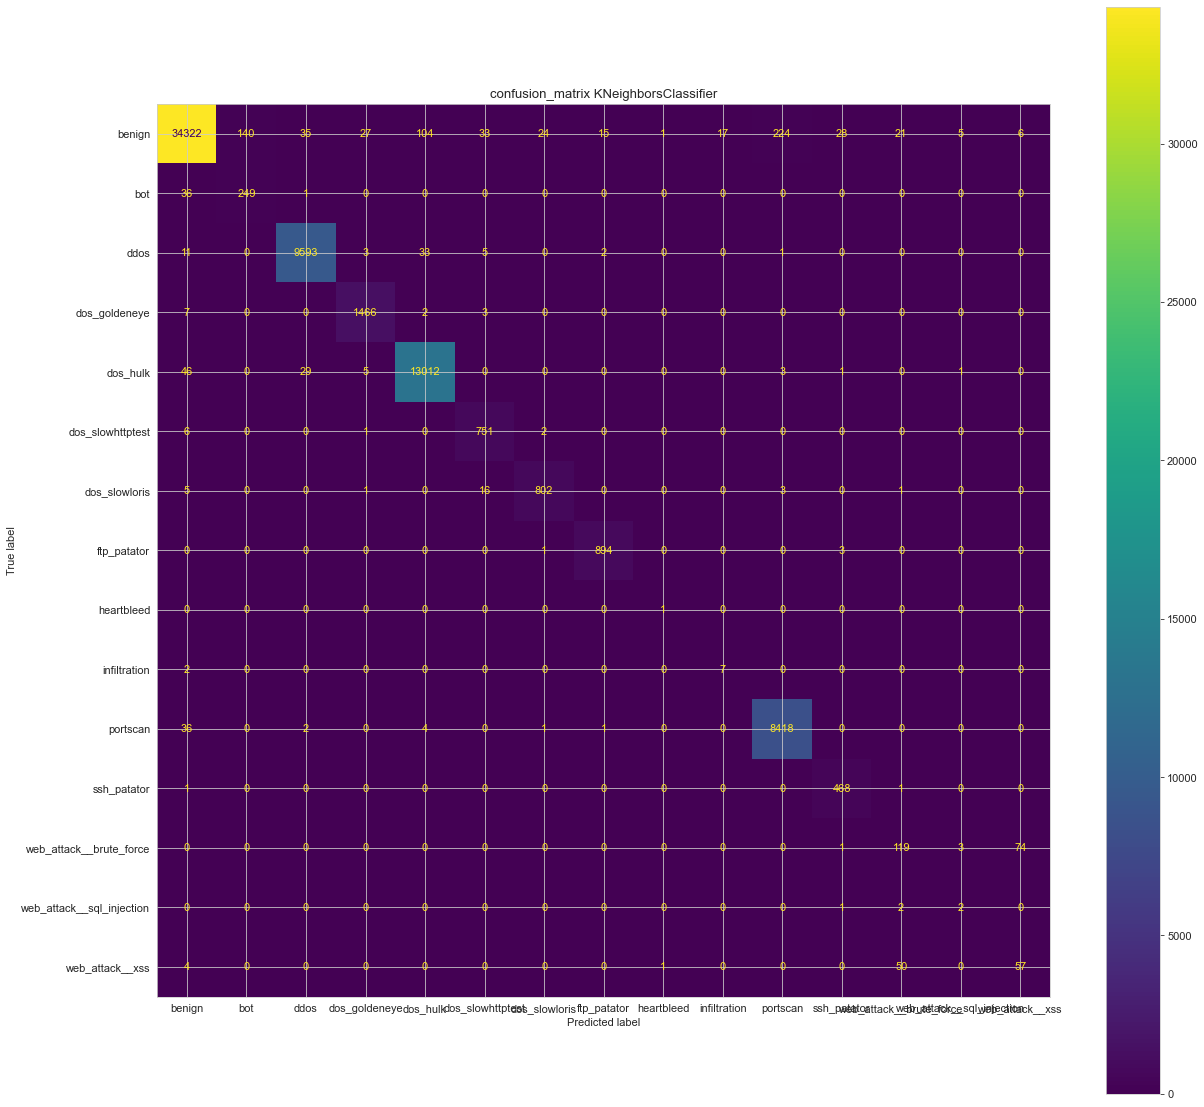

In [49]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_title("confusion_matrix KNeighborsClassifier")
plot_confusion_matrix(model_knn, X_test, y_test, values_format='d', ax=ax );

Из графика видно что больше всего модель ошибается в классе portscan, а лучше всего модель предсказывает нормальный трафик benign. Классы модель не путает. В целом мы получили хорошее предсказание классов.

### Вывод

<br> Перед нами стояла задача мультиклассовой классификации, значение метрик classification_report. <i>Целевой признак - label.</i> <br> Мы подготовили следующий план для реальизации цели:<br>
    <ol>
    <li>Анализ ЕDA</li>
    <li>Подготовка признаков</li>
        <ul>
        <li>Обработка сильно скоррелированных данных</li>
        <li>Добавление и удаление данных</li>
    </ul>
    <li>Анализ моделей</li>
        <ul>
        <li>Деление выборки</li>
        <li>Масштабирование признаков для некотроых моделей</li>
    </ul>
        <li>Обучение моделей</li>
        <ul>
        <li>Обучение лучшей модели</li>
        <li>Визуализация качества модели</li>
    </ul>
    </ol>
    <br> В ходе проекта мы обнаружили данные, которые имеют неинформативные данные, так же в столбце flow_bytes_s были пропущенные значения, мы заменили данные медианным значением. В целевом признаке мы обнаружили несбалансированные данные, 44% составляли данные нормального трафика, 56% составляли 14 признаков злокачественного трафика. В связи с этим мы масштабировали данные целевого признака перед обучением. </br>
    <hr>
    <br>Далее мы поделили выборку на тренировочную, валидационную и тестовую выборку.</br>
    <hr>
    <br>Для обучения мы использовали следующие модели:</br>
        <ul>
        <li>LogisticRegression</li>
        <li>LinearSVC</li>
        <li>DecisionTreeClassifier</li>
        <li>RandomForestClassifier</li>
        <li>KNeighborsClassifier</li>
        <li>AdaBoostClassifier</li>
    </ul>
    <br>Самая высокая метрика accuracy показала на модели KNeighborsClassifier - 0,98. Макросреднее значение точночти показала 0,75, средневзвешанное значение 0,99. Полнота показала нам макросреднее значение 0,87 и 0,98 средневзвешанное значение, значит положительные классы модель предсказала очень хорошо.  f1-score макросреднее значение показало 0,79 и средневзвешанное значение 0,99.</br>
    <br> **Лучшие параметры модели KNeighborsClassifier:**</br>
    <br>param = [{
'n_neighbors': [1],
'random_state': [2023]
}]</br>